In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
df_train = pd.read_csv('../../data/NaiveBayes/train_tweets_Naive_Bayes.csv')
df_val = pd.read_csv('../../data/NaiveBayes/eval_tweets_Naive_Bayes.csv')
df_test = pd.read_csv('../../data/NaiveBayes/test_tweets_Naive_Bayes.csv')

# Validation dataset is not needed
df_train = pd.concat([df_train, df_val], ignore_index=True)

# Feature Selection

# Multiclass Naive Bayes Classifier

Function to perform cross validation.

In [12]:
def train_evaluate_model(train, test, vectorizer, classifier, title, binary = False):
    # Extract features and labels
    X_train, y_train = train["tweet_text"], train["cyberbullying_type"]
    X_test, y_test = test["tweet_text"], test["cyberbullying_type"]

    if binary:
        y = y.astype('int')
    
    # Vectorize text data
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    # Train classifier
    classifier.fit(X_train, y_train)
        
    # Predict on test set
    y_pred = classifier.predict(X_test)
        
    # Generate classification report
    print(classification_report(y_test, y_pred))
    
    # Get the sorted list of unique class labels
    classes = sorted(train['cyberbullying_type'].unique())
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    
    # Plot confusion matrix with title
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Multinomial Naive Bayes Model
- Designed for discrete count-based data (e.g., text data represented by word frequency).	
- Features are counts of occurrences in different classes.
- Text classification, document categorization, sentiment analysis.

                   precision    recall  f1-score   support

              age       0.74      0.98      0.84      1577
        ethnicity       0.87      0.91      0.89      1511
           gender       0.88      0.83      0.86      1525
not_cyberbullying       0.88      0.37      0.52      1381
         religion       0.82      0.97      0.89      1619

         accuracy                           0.82      7613
        macro avg       0.84      0.81      0.80      7613
     weighted avg       0.84      0.82      0.81      7613



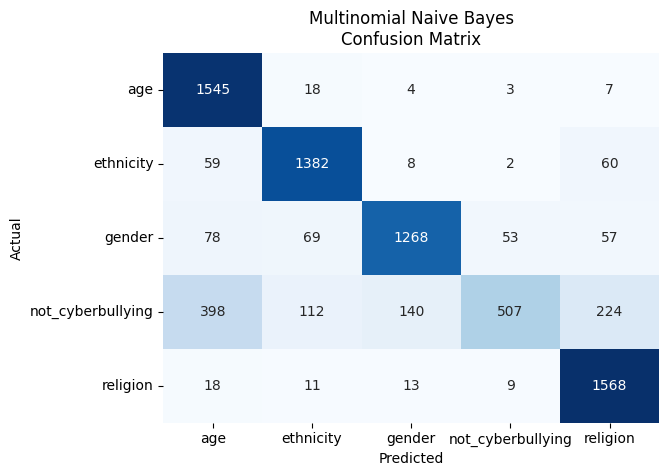

In [13]:

vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
title = 'Multinomial Naive Bayes\nConfusion Matrix'
train_evaluate_model(df_train, df_test, vectorizer, classifier, title)


## Complement Naive Bayes Model
- Designed for categorical data with imbalanced classes.
- Features are represented by attribute frequencies in documents.
- Useful when classes are imbalanced and training data is limited.
- Used in text classification, document categorization, and reviews analysis applications.

                   precision    recall  f1-score   support

              age       0.79      0.97      0.87      1577
        ethnicity       0.87      0.93      0.90      1511
           gender       0.89      0.83      0.86      1525
not_cyberbullying       0.86      0.46      0.60      1381
         religion       0.83      0.98      0.90      1619

         accuracy                           0.84      7613
        macro avg       0.85      0.83      0.83      7613
     weighted avg       0.85      0.84      0.83      7613



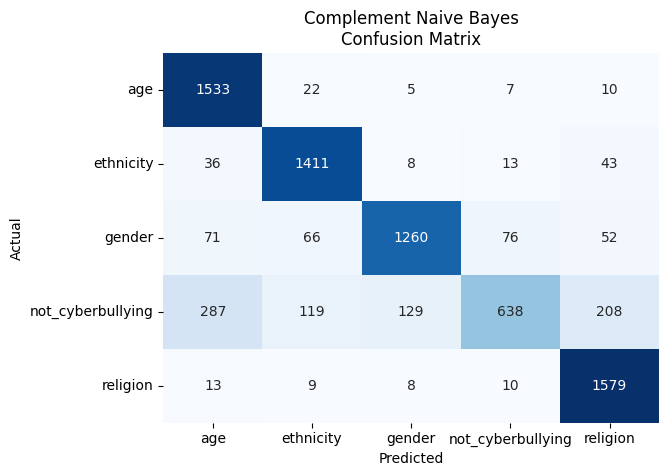

In [15]:
vectorizer = TfidfVectorizer()
classifier = ComplementNB()
title = 'Complement Naive Bayes\nConfusion Matrix'
train_evaluate_model(df_train, df_test, vectorizer, classifier, title)

## Bernoulli Naive Bayes Model

- Designed for discrete count-based data, such as text data represented by word frequency.
- Features are counts of occurrences in different classes.
- Commonly used in text classification, document categorization, and sentiment analysis tasks.

                   precision    recall  f1-score   support

              age       0.97      0.96      0.97      1577
        ethnicity       0.95      0.93      0.94      1511
           gender       0.92      0.80      0.86      1525
not_cyberbullying       0.74      0.86      0.79      1381
         religion       0.91      0.93      0.92      1619

         accuracy                           0.90      7613
        macro avg       0.90      0.90      0.90      7613
     weighted avg       0.90      0.90      0.90      7613



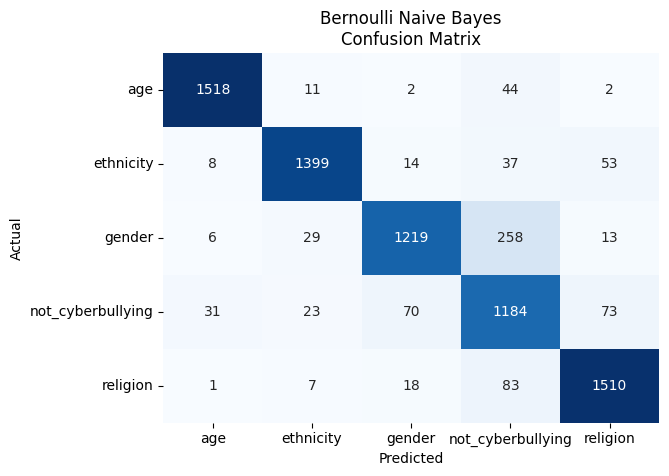

In [17]:
vectorizer = TfidfVectorizer()
classifier = BernoulliNB()
title = 'Bernoulli Naive Bayes\nConfusion Matrix'
train_evaluate_model(df_train, df_test, vectorizer, classifier, title)

# Binary Naive Bayes Classifier

From the original dataset, we selected all the tweets labeled as "not_cyberbullying" and assigned them the category 1. Since there were 7815 such tweets, to achieve a balanced distribution, we selected 1563 tweets for each cyberbullying category and assigned them label 0.

In [28]:
df = pd.read_csv('../../data/normalized_tweets.csv')

# if we drop 'other_cyberbullyng', n changes
# df = df[df['cyberbullying_type'] != 'other_cyberbullying']
# n = 1953

n = 1563

# Create an empty dataframe for the results
result_df = pd.DataFrame(columns=['tweet_text', 'label'])


for category in df['cyberbullying_type'].unique():
    if category != 'not_cyberbullying':
        sampled_df = df[df['cyberbullying_type'] == category].sample(n=n, replace=False)
        sampled_df.loc[:, 'label'] = 0  
        result_df = pd.concat([result_df, sampled_df[['tweet_text', 'label']]], ignore_index=True)
    else:
        other_cyberbullying_df = df[df['cyberbullying_type'] == category].copy() 
        other_cyberbullying_df.loc[:, 'label'] = 1 
        result_df = pd.concat([result_df, other_cyberbullying_df[['tweet_text', 'label']]], ignore_index=True)


## Multinomial Naive Bayes Model

Mean F1 Score: 0.7198815964228065
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      7815
           1       0.83      0.54      0.65      6868

    accuracy                           0.73     14683
   macro avg       0.76      0.72      0.72     14683
weighted avg       0.75      0.73      0.72     14683



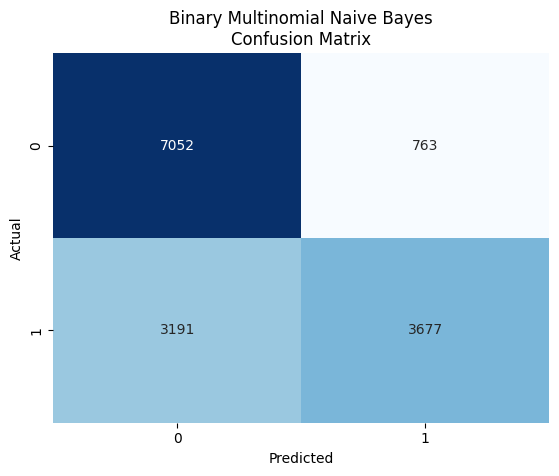

In [29]:
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
title = 'Binary Multinomial Naive Bayes\nConfusion Matrix'
train_evaluate_model(result_df, 'tweet_text', 'label', vectorizer, classifier, title, binary = True)

## Complement Naive Bayes Model

Mean F1 Score: 0.7441806532975376
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      7815
           1       0.81      0.60      0.69      6868

    accuracy                           0.75     14683
   macro avg       0.76      0.74      0.74     14683
weighted avg       0.76      0.75      0.74     14683



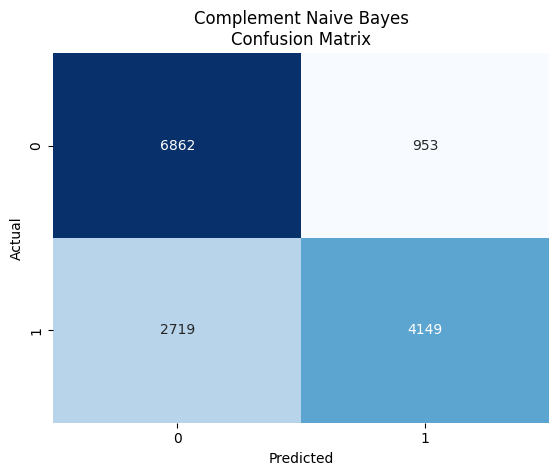

In [30]:
vectorizer = TfidfVectorizer()
classifier = ComplementNB()
title = 'Complement Naive Bayes\nConfusion Matrix'
train_evaluate_model(result_df, 'tweet_text', 'label', vectorizer, classifier, title, binary = True)

## Bernoulli Naive Bayes Model

Mean F1 Score: 0.8133150902896112
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      7815
           1       0.76      0.88      0.81      6868

    accuracy                           0.81     14683
   macro avg       0.82      0.82      0.81     14683
weighted avg       0.82      0.81      0.81     14683



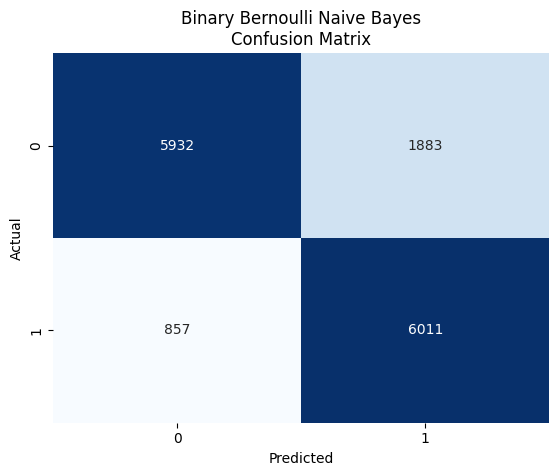

In [31]:
vectorizer = TfidfVectorizer()
classifier = BernoulliNB()
title = 'Binary Bernoulli Naive Bayes\nConfusion Matrix'
train_evaluate_model(result_df, 'tweet_text', 'label', vectorizer, classifier, title, binary = True)